In [1]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

import torch
import torchaudio
import torch.nn as nn
from torch.utils.data import Dataset
from torchsummary import summary

from utils import load

C:\Users\georg\PycharmProjects\information_bottleneck\venv\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [10]:
DATA_DIR = './data/fma_small'

# download data first from these links:
# curl -O https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
# curl -O https://os.unil.cloud.switch.ch/fma/fma_small.zip

tracks = load('./data/fma_metadata/tracks.csv')
subset = tracks.index[tracks['set', 'subset'] <= 'small']

tracks = tracks.loc[subset]
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)

torch.Size([32, 128, 1290])


C:\Users\georg\PycharmProjects\information_bottleneck\utils.py:310: RuntimeWarning: invalid value encountered in log
  cax = ax.matshow(np.log(spectrogram), origin='lower', aspect='auto', cmap='inferno')


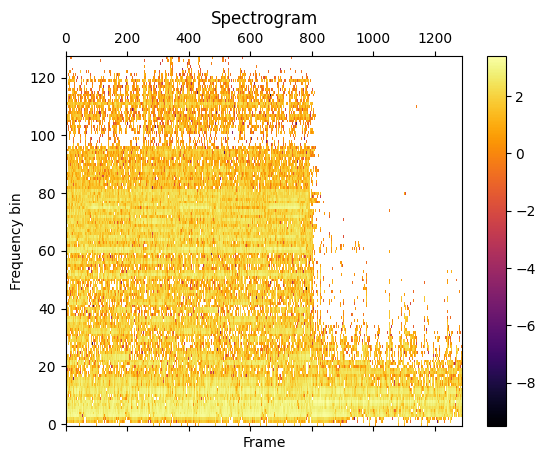

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 64, 645]             208
            Conv2d-2           [-1, 8, 64, 645]             208
              ReLU-3           [-1, 8, 64, 645]               0
              ReLU-4           [-1, 8, 64, 645]               0
       BatchNorm2d-5           [-1, 8, 64, 645]              16
       BatchNorm2d-6           [-1, 8, 64, 645]              16
            Conv2d-7          [-1, 16, 32, 323]           1,168
            Conv2d-8          [-1, 16, 32, 323]           1,168
              ReLU-9          [-1, 16, 32, 323]               0
             ReLU-10          [-1, 16, 32, 323]               0
      BatchNorm2d-11          [-1, 16, 32, 323]              32
      BatchNorm2d-12          [-1, 16, 32, 323]              32
           Conv2d-13          [-1, 32, 16, 162]           4,640
           Conv2d-14          [-1, 32, 

In [29]:
BATCH = 32
EPOCHS = 5
augment_prob = 0.8


# create a training dataset and dataloader
dataset_train = FMA2D_spec(DATA_DIR, train, transforms = False)
dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=BATCH, shuffle=True)

# create a validation dataset and dataloader
dataset_valid = FMA2D_spec(DATA_DIR, val, transforms = False)
val_dataloader = torch.utils.data.DataLoader(dataset_valid, batch_size=BATCH, shuffle=True)

# define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()

# Lee 2017
# SGD optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)

from utils import plot_spectrogram
for spec, label in dataloader:
    print(spec.size())
    plot_spectrogram(spec[0])
    input_size = spec.size()[2]
    break

p_dropout = 0.3
#model = ResNet(FN=64, p_dropout=p_dropout)
model = SimpleCNN()
model.to(device)


summary(model, (1, 128, 1290))

# Adam optimizer01
lr = 0.001
optimizer = torch.optim.Adam(model.parameters())

timestamp = time.strftime("feb%d_t%H%M", time.gmtime())
model_name = f"{model.name}_B{BATCH}_E{EPOCHS}_O{optimizer_name}_LR{lr}_pD{p_dropout}_A{augment_prob}_{timestamp}"

In [30]:
i = 0
running_loss = 0.0
best_val_loss = float('inf') # initialize the best validation loss


# train the model
acc_tr = []
acc_val = []
loss_tr = []
loss_val = []

t0 = time.time()

for epoch in range(EPOCHS):
    # evaluate the model on the training dataset
    train_correct = 0
    train_total = 0
    for spectrogram, label in dataloader:
            model.train()
            label = label.to(device)
            train_label = torch.argmax(label, dim=1)



            # forward pass
            spectrogram = spectrogram.squeeze(0)  
            spectrogram = spectrogram.unsqueeze(1)
            
            spectrogram = spectrogram.to(device)
            output = model(spectrogram)
            
            loss = loss_fn(output, label)

            # backward pass
            optimizer.zero_grad()
            model.zero_grad()
            loss.backward()
            optimizer.step()  
            
            # Update the learning rate
            # scheduler.step(loss)
            
            _, train_predicted = torch.max(output.data, 1)
            train_total += train_label.size(0)
            train_correct += (train_predicted == train_label).sum().item()
            # print statistics
            i += 1
            running_loss += loss.item()
            
            
    loss = running_loss / len(dataloader)
    loss_tr.append(loss)
    print('[%d, %5d subsamples] Training loss: %.3f' % (epoch + 1, i*BATCH, loss))
    running_loss = 0            
    # evaluate the model on the validation dataset
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    model.eval()
    with torch.no_grad():
        for val_spectrogram, val_label in val_dataloader:
                val_label = val_label.to(device)
                val_label = torch.argmax(val_label, dim=1)
            
                val_spectrogram = val_spectrogram.squeeze(0)
                val_spectrogram = val_spectrogram.unsqueeze(1)
                val_spectrogram = val_spectrogram.to(device)
                val_output = model(val_spectrogram)
                val_loss += loss_fn(val_output, val_label).item()
                _, val_predicted = torch.max(val_output.data, 1)
                val_total += val_label.size(0)
                val_correct += (val_predicted == val_label).sum().item()

    loss = val_loss / len(val_dataloader)
    loss_val.append(loss)
    val_acc = val_correct / val_total
    tr_acc = train_correct / train_total 
    acc_tr.append(tr_acc)
    acc_val.append(val_acc)
    t1 = time.time()
    t = (t1 - t0)/60
    # Save the model if the validation loss is the best seen so far
    if loss < best_val_loss:
        best_val_loss = loss
        best_val_acc = val_acc
        best_tr_acc = tr_acc
        best_state_dict = model.state_dict()
    print('[{:.4f} min] Validation Loss: {:.4f} | Validation Accuracy: {:.4f} | Training Accuracy: {:.4f}'.format(t, loss, val_acc, tr_acc))

plt.plot(loss_val, label='Validation loss')
plt.plot(loss_tr, label='Training loss')
plt.show()

plt.plot(acc_val, label='Validation accuracy')
plt.plot(acc_tr, label='Training accuracy')
plt.show()

torch.save(best_state_dict, model_name + f'_VAL{best_val_acc}_TRAIN{best_tr_acc}.pt')
print('Finished Training')

[1,  6400 subsamples] Training loss: 1.675
[0.2895 min] Validation Loss: 1.6715 | Validation Accuracy: 0.3787 | Training Accuracy: 0.3905


KeyboardInterrupt: 

In [ ]:
# in case we keyboard interrupt the training process we can save the best model manually:
torch.save(best_state_dict, model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
print(model_name + f'_VAL{best_val_acc:.4f}_TRAIN{best_tr_acc:.4f}.pt')
# model_name = "nnet1_2022-01-30_batchsize_32_epochs_100_opt_Adam_LR_0.0001_dropout1_acc0.373_subsampling"
# torch.save(model, model_name + '.pt')